In [81]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [158]:
# Load the dataset
data = pd.read_csv(r'D:\ML Repositories\Price_forecasting_project\data\raw\processed\Delicious_A_dataset.csv')

In [159]:
data

,Date,District,Market,Fruit,Variety,Grade,Min Price (per kg),Max Price (per kg),Avg Price (per kg),Mask
0,2017-09-01,NaN,NaN,NaN,Delicious,A,0.0,0.0,0.00,0
1,2017-09-02,NaN,NaN,NaN,Delicious,A,0.0,0.0,0.00,0
2,2017-09-03,NaN,NaN,NaN,Delicious,A,0.0,0.0,0.00,0
3,2017-09-04,NaN,NaN,NaN,Delicious,A,0.0,0.0,0.00,0
4,2017-09-05,NaN,NaN,NaN,Delicious,A,0.0,0.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...
2674,2024-12-27,Shopian,Aglar,Apple,Delicious,A,50.0,62.5,56.25,1
2675,2024-12-28,Shopian,Aglar,Apple,Delicious,A,50.0,62.5,56.25,1
2676,2024-12-29,Shopian,Aglar,Apple,Delicious,A,50.0,62.5,56.25,1
2677,2024-12-30,Shopian,Aglar,Apple,Delicious,A,50.0,62.5,56.25,1


In [160]:
data.columns

Index(['Date', 'District', 'Market', 'Fruit', 'Variety', 'Grade',
       'Min Price (per kg)', 'Max Price (per kg)', 'Avg Price (per kg)',
       'Mask'],
      dtype='object')

In [161]:
# Ensure proper datetime format for models requiring 'ds'
data = data.rename(columns={"Date": "ds", "Avg Price (per kg)": "y"})
data['ds'] = pd.to_datetime(data['ds'])

In [162]:
# Filter for available data (Mask=1) for SARIMA and Prophet
available_data = data[data['Mask'] == 1].copy()

In [163]:
# Split data for training and testing
train_data = available_data[available_data['ds'] < '2023-01-01']
test_data = available_data[available_data['ds'] >= '2023-01-01']

In [164]:
# Create a function to reverse scaling
def reverse_scaling(scaled_values, data):
    return scaled_values * (data['y'].max() - data['y'].min()) + data['y'].min()

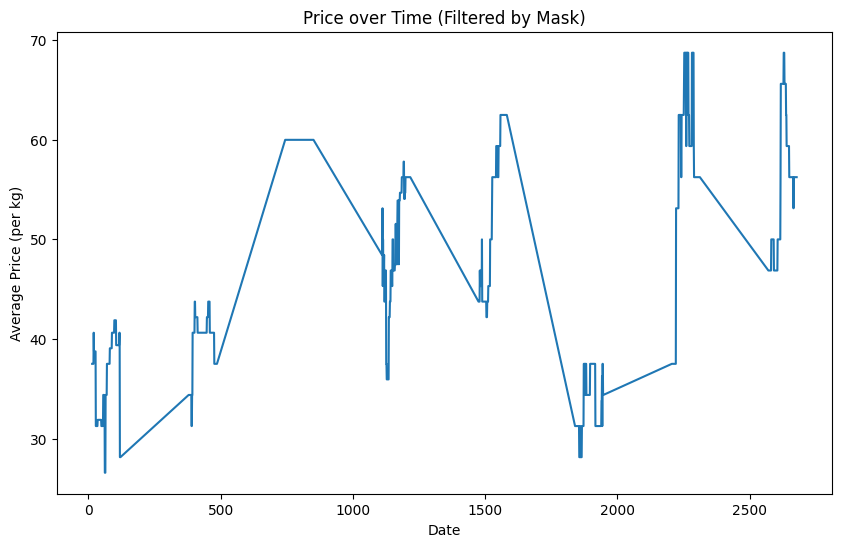

In [165]:
# Visualize the filtered data
plt.figure(figsize=(10,6))
plt.plot(available_data['y'])
plt.title('Price over Time (Filtered by Mask)')
plt.xlabel('Date')
plt.ylabel('Average Price (per kg)')
plt.show()

In [101]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

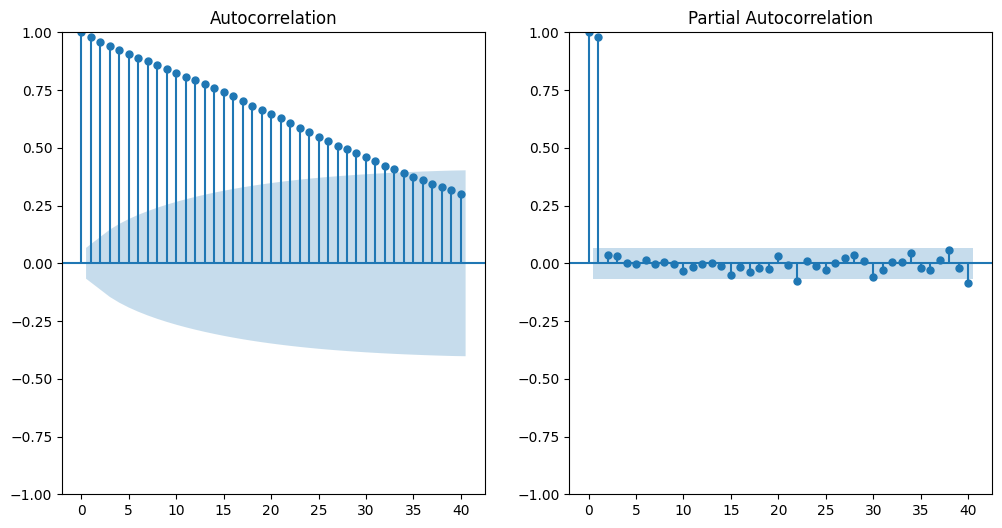

In [102]:
# Plot ACF and PACF for the given time series
plt.figure(figsize=(12, 6))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(available_data['y'], lags=40, ax=plt.gca())

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(available_data['y'], lags=40, ax=plt.gca())

plt.show()


In [25]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the range of parameters for grid search
p_values = range(0, 3)  # AR terms
d_values = range(0, 2)  # Differencing terms
q_values = range(0, 3)  # MA terms
P_values = range(0, 3)  # Seasonal AR terms
D_values = range(0, 2)  # Seasonal differencing terms
Q_values = range(0, 3)  # Seasonal MA terms
seasonal_periods = [12]  # Seasonal period (e.g., 12 for monthly data with yearly seasonality)

# Prepare parameter combinations
param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, seasonal_periods))

# Initialize a list to store results
results = []

# Loop through all parameter combinations
for param in param_grid:
    try:
        # Unpack the parameters
        p, d, q, P, D, Q, S = param
        
        # Define and fit the SARIMA model with the current parameters
        sarima_model = SARIMAX(data_filtered['Avg Price (per kg)'],
                               order=(p, d, q),             # (p, d, q)
                               seasonal_order=(P, D, Q, S),  # (P, D, Q, S)
                               enforce_stationarity=False,   # Avoid stationarity constraint for SARIMA
                               enforce_invertibility=False)  # Avoid invertibility constraint for SARIMA
        
        # Fit the model
        sarima_results = sarima_model.fit(disp=False)
        
        # Store the model parameters and AIC
        results.append((param, sarima_results.aic))
    except Exception as e:
        print(f"Error fitting model with parameters {param}: {e}")
        continue

# Convert the results into a DataFrame
results_df = pd.DataFrame(results, columns=["Params", "AIC"])

# Sort by AIC and display the best parameters
best_params = results_df.sort_values(by="AIC").iloc[0]
print("Best Parameters:", best_params)


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so wil

Best Parameters: Params    (1, 0, 2, 0, 1, 2, 12)
AIC                  3743.214764
Name: 149, dtype: object


In [166]:
#######################################
# SARIMA Model
#######################################
sarima_model = SARIMAX(train_data['y'], 
                       order=(1, 0, 2),
                       seasonal_order=(0, 1, 2, 12))
sarima_results = sarima_model.fit(disp=False)

sarima_forecast = sarima_results.get_forecast(steps=len(test_data))
sarima_pred = sarima_forecast.predicted_mean


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the ne

In [212]:
sarima_pred

648    33.085369
649    33.339693
650    33.592183
651    33.749336
652    34.081672
         ...    
858    40.676033
859    40.362380
860    41.009164
861    41.328685
862    41.289173
Name: predicted_mean, Length: 215, dtype: float64

In [170]:
#######################################
# Prophet Model
#######################################
prophet_model = Prophet()
prophet_model.fit(train_data[['ds', 'y']].rename(columns={'ds': 'ds', 'y': 'y'}))

future = prophet_model.make_future_dataframe(periods=len(test_data))
prophet_forecast = prophet_model.predict(future)
prophet_pred = prophet_forecast['yhat'][-len(test_data):]

16:29:08 - cmdstanpy - INFO - Chain [1] start processing
16:29:08 - cmdstanpy - INFO - Chain [1] done processing


In [213]:
prophet_pred

648    32.783466
649    32.714582
650    32.689149
651    32.378599
652    32.032686
         ...    
858    23.604615
859    25.605401
860    27.546921
861    29.058458
862    30.351445
Name: yhat, Length: 215, dtype: float64

In [180]:
# Generate lagged features
def create_lagged_features(data, max_lag):
    for lag in range(1, max_lag + 1):
        data[f'y_lag{lag}'] = data['y'].shift(lag)
    return data

# Prepare the dataset
max_lag = 50  # Test up to 10 lags
data_filtered = create_lagged_features(data, max_lag)
data_filtered = data_filtered.dropna()  # Drop rows with NaN values from lagging

# Split the data after creating lagged features
train_data = data[data['ds'] < '2023-01-01']
test_data = data[data['ds'] >= '2023-01-01']

# Add 'Mask' as a feature
features = [f'y_lag{i}' for i in range(1, max_lag + 1)] + ['Mask']

# Define training and testing features and labels
X_train, y_train = train_data[features], train_data['y']
X_test, y_test = test_data[features], test_data['y']
# Find the optimal number of lags
best_lags = 0
best_mse = float('inf')
results = []

for num_lags in range(1, max_lag + 1):
    lag_features = features[:num_lags] + ['Mask']
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train[lag_features], y_train)
    predictions = rf_model.predict(X_test[lag_features])
    mse = mean_squared_error(y_test, predictions)
    results.append((num_lags, mse))
    if mse < best_mse:
        best_mse = mse
        best_lags = num_lags

# Output the best number of lags
print(f"Best number of lags: {best_lags} with MSE: {best_mse}")

Best number of lags: 1 with MSE: 3.5898099622580224


In [ ]:
rf_pred_aligned = rf_pred[test_data['Mask'] == 1]

In [193]:
# Train and evaluate the final Random Forest model with optimal lags
optimal_features = features[:best_lags] + ['Mask']

# Train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train[optimal_features], y_train)

# Predict and handle decimal predictions
xgb_pred = xgb_model.predict(X_test[optimal_features])
xgb_pred_rounded = xgb_pred.round()  # Round predictions if integers are expected

In [195]:
xgb_pred_aligned = xgb_pred_rounded[test_data['Mask'] == 1]

In [197]:
xgb_pred_aligned.shape

(215,)

In [198]:
#######################################
# LSTM Model with Different Lags
#######################################
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Evaluate different sequence lengths (lags)
lags = [1, 2, 3, 5, 10, 15, 20, 30]  # List of lags to try
best_mse = float('inf')  # Initialize best MSE as a large number
best_seq_length = None
best_lstm_pred = None

for seq_length in lags:
    scaled_y = (data['y'] - data['y'].min()) / (data['y'].max() - data['y'].min())  # Min-max scaling
    X, y = create_sequences(scaled_y.values, seq_length)

    X_train, X_test = X[:-len(test_data)], X[-len(test_data):]
    y_train, y_test = y[:-len(test_data)], y[-len(test_data):]

    # Reshape input for LSTM: [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    lstm_model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, 1)),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')

    # Train the LSTM model
    lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Make predictions
    lstm_pred = lstm_model.predict(X_test)

    # Reverse scaling to get predictions back to original values
    lstm_pred = lstm_pred * (data['y'].max() - data['y'].min()) + data['y'].min()

    # Calculate MSE for the current sequence length
    mse = mean_squared_error(y_test, lstm_pred)

    # Update best MSE and best sequence length
    if mse < best_mse:
        best_mse = mse
        best_seq_length = seq_length
        best_lstm_pred = lstm_pred

# Print the best sequence length and its MSE
print(f"Best Sequence Length (Lag): {best_seq_length}")
print(f"Best MSE: {best_mse}")



c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Best Sequence Length (Lag): 3
Best MSE: 851.3622438964901


In [201]:
#######################################
# LSTM Model
#######################################
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 3
scaled_y = (data['y'] - data['y'].min()) / (data['y'].max() - data['y'].min())  # Min-max scaling
X, y = create_sequences(scaled_y.values, seq_length)

X_train, X_test = X[:-len(test_data)], X[-len(test_data):]
y_train, y_test = y[:-len(test_data)], y[-len(test_data):]

lstm_model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)
lstm_pred = lstm_model.predict(X_test)
lstm_pred = reverse_scaling(lstm_pred, data)  # Reverse scaling

# Align LSTM predictions to Mask=1 data in test set
lstm_pred_aligned = lstm_pred[test_data['Mask'] == 1]

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0964
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033   
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047   
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046   
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033   
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035   
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033   
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025   
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051
Epoch 13/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024   
Epoch 14/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036   
Epoch 15/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [203]:
lstm_pred_aligned.shape

(215, 1)

In [205]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#######################################
# Transformer Model
#######################################
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_layers):
        super(TransformerModel, self).__init__()
        
        # Embedding layer to map input_dim to embed_dim
        self.embedding = nn.Linear(input_dim, embed_dim)
        
        # Transformer layers
        self.encoder_layer = nn.TransformerEncoderLayer(embed_dim, num_heads, ff_dim)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers)
        
        # Output layer
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        # Embed the input to match embed_dim
        x = self.embedding(x)
        
        # Transformer expects the shape (seq_len, batch, embed_dim)
        x = x.permute(1, 0, 2)  # Change shape to (seq_len, batch_size, embed_dim)
        
        # Pass through the transformer
        x = self.transformer(x)
        
        # Return the average of the output sequence and pass through the final layer
        return self.fc(x.mean(dim=0))

# Initialize the model
transformer = TransformerModel(input_dim=1, embed_dim=16, num_heads=2, ff_dim=64, num_layers=2)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)

# Assuming X_train and y_train are your training data
train_dataset = TimeSeriesDataset(torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1),  # [batch, seq_length, 1] shape
                                   torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
for epoch in range(100):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = transformer(batch_X)  # [batch_size, seq_length, input_dim] shape
        loss = criterion(outputs.squeeze(), batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()

# Evaluation mode
transformer.eval()
x_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)  # [batch_size, seq_length, 1] shape
transformer_pred = transformer(x_test_tensor).detach().numpy()

# Reverse scaling for Transformer predictions
transformer_pred = reverse_scaling(transformer_pred, data)

# Align Transformer predictions to Mask=1 data in test set
transformer_pred_aligned = transformer_pred[test_data['Mask'] == 1]

In [210]:
sarima_pred_aligned.shape

(323,)

In [214]:
#######################################
# Evaluate Models
#######################################
def evaluate_model(true, pred):
    mse = mean_squared_error(true, pred)
    mae = mean_absolute_error(true, pred)
    return mse, mae

# Evaluate all models
sarima_mse, sarima_mae = evaluate_model(test_data['y'][test_data['Mask'] == 1], sarima_pred)
prophet_mse, prophet_mae = evaluate_model(test_data['y'][test_data['Mask'] == 1], prophet_pred)
rf_mse, rf_mae = evaluate_model(test_data['y'][test_data['Mask'] == 1], rf_pred_aligned)
xgb_mse, xgb_mae = evaluate_model(test_data['y'][test_data['Mask'] == 1], xgb_pred_aligned)
lstm_mse, lstm_mae = evaluate_model(test_data['y'][test_data['Mask'] == 1], lstm_pred_aligned)
transformer_mse, transformer_mae = evaluate_model(test_data['y'][test_data['Mask'] == 1], transformer_pred_aligned)

In [215]:
# Create a comparison DataFrame
model_comparison = pd.DataFrame({
    'Model': ['SARIMA', 'Prophet', 'Random Forest', 'XGBoost', 'LSTM', 'Transformer'],
    'MSE': [sarima_mse, prophet_mse, rf_mse, xgb_mse, lstm_mse, transformer_mse],
    'MAE': [sarima_mae, prophet_mae, rf_mae, xgb_mae, lstm_mae, transformer_mae]
})

# Sort models by MSE and MAE
model_comparison_sorted = model_comparison.sort_values(by='MSE')

print(model_comparison_sorted)

           Model          MSE        MAE
2  Random Forest    12.205354   1.744873
3        XGBoost    13.083721   1.936047
4           LSTM    45.556272   2.028933
5    Transformer    57.468093   3.775005
0         SARIMA   356.240035  17.071906
1        Prophet  1091.144796  30.818304


C:\Windows\Temp\ipykernel_8812\809461196.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_comparison_sorted, x='Model', y='MSE', palette='viridis')


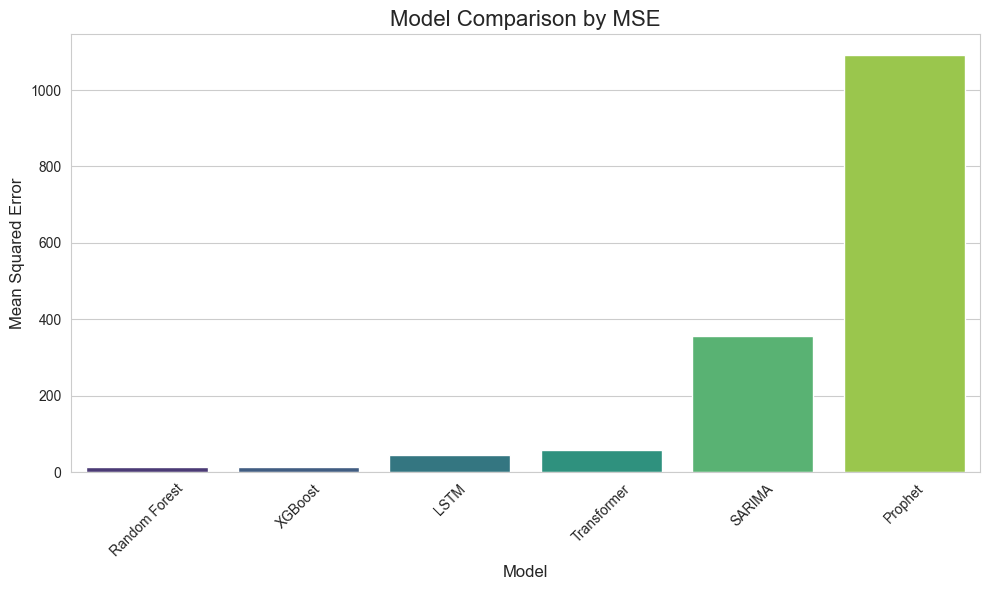

C:\Windows\Temp\ipykernel_8812\809461196.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_comparison_sorted, x='Model', y='MAE', palette='coolwarm')


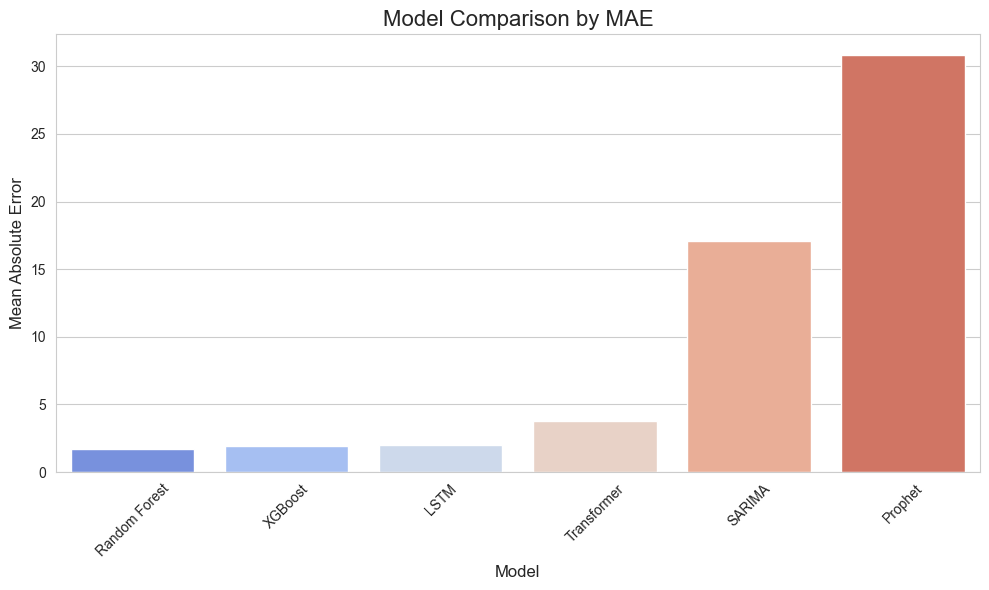

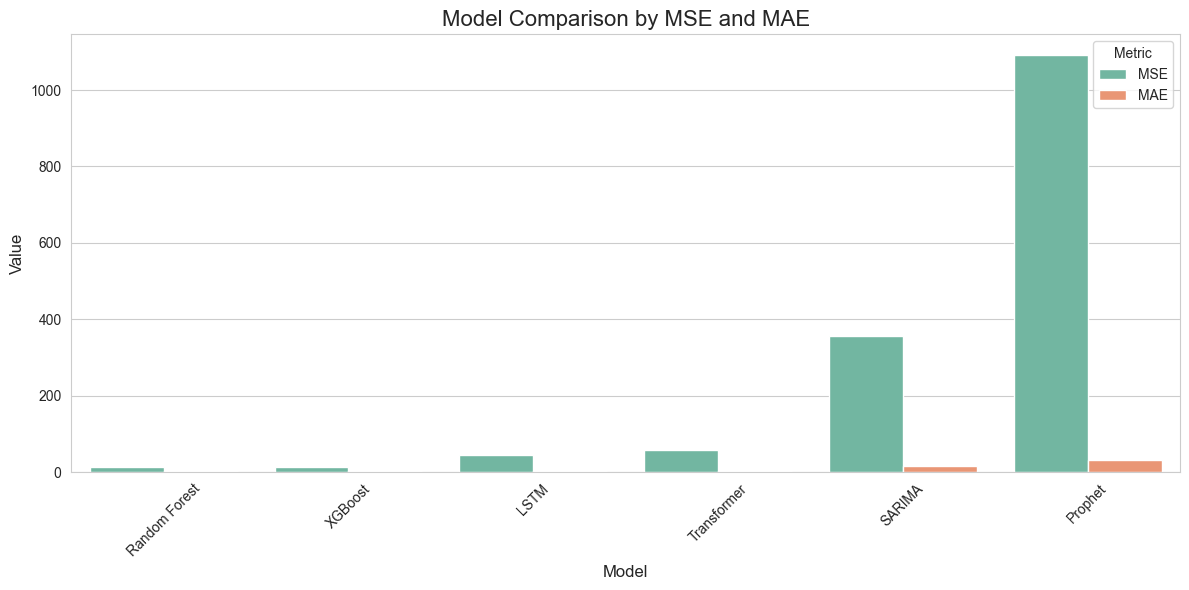

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style('whitegrid')

# Plot MSE for each model
plt.figure(figsize=(10, 6))
sns.barplot(data=model_comparison_sorted, x='Model', y='MSE', palette='viridis')
plt.title('Model Comparison by MSE', fontsize=16)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot MAE for each model
plt.figure(figsize=(10, 6))
sns.barplot(data=model_comparison_sorted, x='Model', y='MAE', palette='coolwarm')
plt.title('Model Comparison by MAE', fontsize=16)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot MSE and MAE together as a grouped bar plot
melted_comparison = model_comparison_sorted.melt(id_vars='Model', var_name='Metric', value_name='Value')
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_comparison, x='Model', y='Value', hue='Metric', palette='Set2')
plt.title('Model Comparison by MSE and MAE', fontsize=16)
plt.ylabel('Value', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.legend(title='Metric', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


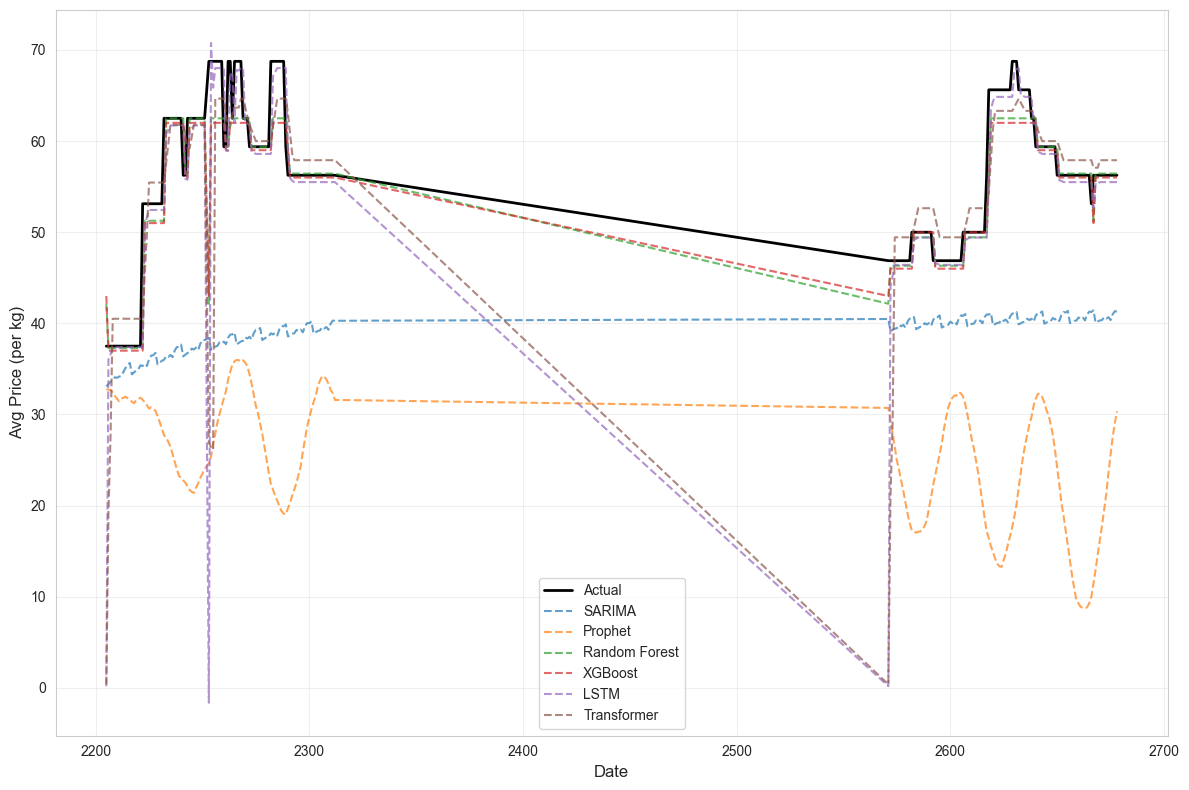

In [219]:
import matplotlib.pyplot as plt

# Actual test values for Mask=1
actual_values = test_data['y'][test_data['Mask'] == 1]

# Plot predictions for each model
plt.figure(figsize=(12, 8))

plt.plot(actual_values.index, actual_values, label='Actual', color='black', linewidth=2)

# Add model predictions
plt.plot(actual_values.index, sarima_pred, label='SARIMA', linestyle='--', alpha=0.7)
plt.plot(actual_values.index, prophet_pred, label='Prophet', linestyle='--', alpha=0.7)
plt.plot(actual_values.index, rf_pred_aligned, label='Random Forest', linestyle='--', alpha=0.7)
plt.plot(actual_values.index, xgb_pred_aligned, label='XGBoost', linestyle='--', alpha=0.7)
plt.plot(actual_values.index, lstm_pred_aligned, label='LSTM', linestyle='--', alpha=0.7)
plt.plot(actual_values.index, transformer_pred_aligned, label='Transformer', linestyle='--', alpha=0.7)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Avg Price (per kg)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()
